In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
# Technically not necessary in newest versions of jupyter
%matplotlib inline

In [2]:
data_dir = "data"

In [4]:
os.listdir(data_dir)

['test', 'train']

In [5]:
test_path = data_dir+"\\test\\"
train_path = data_dir+"\\train\\"

In [8]:
os.listdir(test_path)

['food', 'fundus', 'rose', 'sunflower', 'tulip']

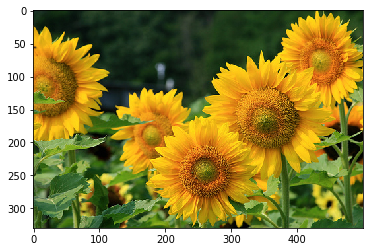

In [14]:
sunflower = os.listdir(train_path+"\\sunflower")[0]
img = train_path+"\\sunflower\\"+sunflower
plt.imshow(imread(img))

In [16]:
image_shape = (224,224,3)

### Image Preprocessing

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [31]:
image_gen = ImageDataGenerator(rotation_range=20,
                              width_shift_range=0.10,
                              height_shift_range=0.10,
                              rescale=1/255,
                              zoom_range=0.10,
                              horizontal_flip=True,
                                fill_mode='nearest'
                              )

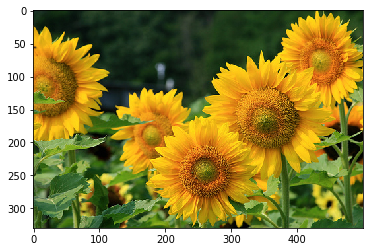

In [22]:
plt.imshow(imread(img))

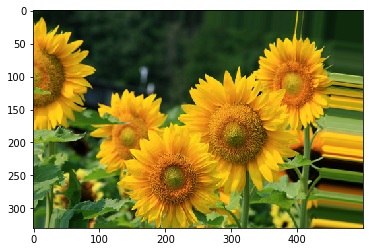

In [34]:
plt.imshow(image_gen.random_transform(imread(img)))

### Generating manipulated images from directory

In [36]:
image_gen.flow_from_directory(train_path)

Found 3419 images belonging to 5 classes.


In [37]:
image_gen.flow_from_directory(test_path)

Found 770 images belonging to 5 classes.


### Creating the Model

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Activation, Flatten, Dropout 

In [44]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=image_shape, activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters=64, kernel_size=(3,3), input_shape=image_shape, activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters=64, kernel_size=(3,3), input_shape=image_shape, activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Flatten())

model.add(Dense(units=128, activation="relu"))

model.add(Dropout(0.5))

model.add(Dense(units=5, activation="softmax"))

model.compile(loss="categorical_crossentropy",optimizer="adam", metrics=["accuracy"])

In [45]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 52, 52, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 43264)            

### Early Stopping

In [47]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor="val_loss", patience=2)

### Training the Model

In [49]:
batch_size=16

In [50]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                                batch_size=batch_size,
                                               class_mode='categorical'
                                               )

Found 3419 images belonging to 5 classes.


In [51]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                              target_size=image_shape[:2],
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False)

Found 770 images belonging to 5 classes.


In [52]:
train_image_gen.class_indices

{'food': 0, 'fundus': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

In [55]:
import warnings
warnings.filterwarnings('ignore')
import math
 
TRAINING_SIZE = 3419
 
VALIDATION_SIZE = 770
 
# We take the ceiling because we do not drop the remainder of the batch
compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / batch_size))
 
steps_per_epoch = compute_steps_per_epoch(TRAINING_SIZE)
val_steps = compute_steps_per_epoch(VALIDATION_SIZE)

In [59]:
model.fit_generator(train_image_gen,
                   epochs=20,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=test_image_gen,
                    validation_steps= val_steps,
                   callbacks=[early_stop])

Epoch 1/20
214/214 [==============================] - 470s 2s/step - loss: 1.0357 - acc: 0.5624 - val_loss: 0.7833 - val_acc: 0.6727
Epoch 2/20
214/214 [==============================] - 471s 2s/step - loss: 0.7254 - acc: 0.7034 - val_loss: 0.6668 - val_acc: 0.7221
Epoch 3/20
214/214 [==============================] - 491s 2s/step - loss: 0.6723 - acc: 0.7280 - val_loss: 0.6998 - val_acc: 0.7182
Epoch 4/20
214/214 [==============================] - 471s 2s/step - loss: 0.6380 - acc: 0.7482 - val_loss: 0.5585 - val_acc: 0.7610
Epoch 5/20
214/214 [==============================] - 311s 1s/step - loss: 0.5619 - acc: 0.7722 - val_loss: 0.5727 - val_acc: 0.7416
Epoch 6/20
214/214 [==============================] - 248s 1s/step - loss: 0.5444 - acc: 0.7882 - val_loss: 0.5372 - val_acc: 0.7688
Epoch 7/20
214/214 [==============================] - 285s 1s/step - loss: 0.5258 - acc: 0.7891 - val_loss: 0.6140 - val_acc: 0.7403
Epoch 8/20
214/214 [==============================] - 279s 1s/step - 

In [60]:
model.save('cnn_classifier.h5')

### Evaluating the model

In [61]:
lossses = pd.DataFrame(model.history.history)

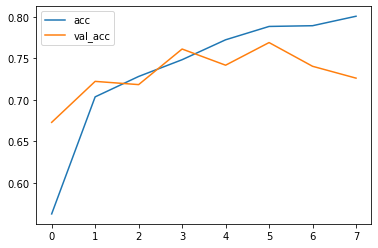

In [66]:
lossses[['acc','val_acc']].plot()

In [67]:
model.metrics_names

['loss', 'acc']

In [68]:
model.evaluate_generator(test_image_gen)

[0.5881883218031102, 0.72337663]

### Predicting on image

In [82]:
from tensorflow.keras.preprocessing import image

my_image = image.load_img(test_path+"\\sunflower\\"+"16975010069_7afd290657_m.jpg",target_size=image_shape)

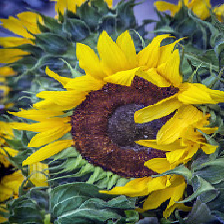

In [83]:
my_image

In [84]:
my_image = image.img_to_array(my_image)

In [85]:
type(my_image)

numpy.ndarray

In [86]:
my_image.shape

(224, 224, 3)

In [87]:
my_image = np.expand_dims(my_image, axis=0)

In [88]:
my_image.shape

(1, 224, 224, 3)

In [89]:
model.predict(my_image)

array([[0., 0., 0., 1., 0.]], dtype=float32)

In [80]:
test_image_gen.class_indices

{'food': 0, 'fundus': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}